In [21]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom 
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects

def _resize_image(image, target):
    return cv2.resize(image, dsize=(target[0], target[1]), interpolation=cv2.INTER_LINEAR)
def load_scan(path):
    slices = [Image.open(path + '/' + s) for s in os.listdir(path)]
    return slices
def normalization(image):
    return (image - image.min())/(image.max() - image.min())

collection = os.listdir('./Data/test')

idx = 0
classes = 0
CTimages = np.zeros((864,256,256,3))
CTclasses = np.zeros(864)
for Cancer_classes in collection:
    if(Cancer_classes == '.DS_Store'):
        continue
    images = load_scan('./Data/test/'+ Cancer_classes)
    images = [np.array(i) for i in images]
    images = [cv2.resize(i,(256,256), interpolation=cv2.INTER_CUBIC) for i in images]
    print(len(images))
    for image in images:
        #print(image.shape)
        #plt.imshow(image[:,:,0:3])
        #plt.show()
        if(image.shape == (256,256)):
            #image = np.reshape(image,(256,256,1))
            continue
            #image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        CTimages[idx,:,:,:] = normalization(image[:,:,0:3])
        CTclasses[idx] = classes
        idx+=1
    classes+=1

CTimages = CTimages[0:idx]
CTclasses = CTclasses[0:idx]
print(CTimages.shape)
print(CTclasses.shape)
    



242
156
310
156
(861, 256, 256, 3)
(861,)


In [22]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(CTimages, CTclasses, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_test = keras.utils.to_categorical(y_test, num_classes=4)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(688, 256, 256, 3)
(173, 256, 256, 3)
(688, 4)
(173, 4)


In [37]:
Trainpixels=X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[2]
Testpixels=X_test.shape[0]*X_test.shape[1]*X_test.shape[2]*X_test.shape[2]

print(np.sum(X_train)/wholepixels)
print(np.sum(X_test)/Testpixels)
print(np.std(X_train))
print(np.std(X_test))

top1 = X_train.flatten('K')
top1 = np.sort(top1)



#fig = plt.figure()

#plt.bar(Trainpixels,top1[Trainpixels-Trainpixels/2])
#plt.show()


0.003465798979975802
0.0034791852740570753
0.2589310236826019
0.263387133996508
(0,)


In [3]:
def data_enhance(X_train,y_train):
  CT_threshold = X_train
  C = y_train

  for i in range(5):
      indices = CT_threshold > 0.8-i*0.1
      CT_threshold[indices]=0.7-i*0.1
      X_train = np.concatenate((X_train, CT_threshold), axis=0)
      y_train = np.concatenate((y_train, C), axis=0)
      print(X_train.shape)
      print(y_train.shape)
  return X_train,y_train

X_train, y_train = data_enhance(X_train, y_train)
X_test, y_test = data_enhance(X_test, y_test)


(1376, 256, 256, 3)
(1376, 4)
(2064, 256, 256, 3)
(2064, 4)
(2752, 256, 256, 3)
(2752, 4)
(3440, 256, 256, 3)
(3440, 4)
(4128, 256, 256, 3)
(4128, 4)
(346, 256, 256, 3)
(346, 4)
(519, 256, 256, 3)
(519, 4)
(692, 256, 256, 3)
(692, 4)
(865, 256, 256, 3)
(865, 4)
(1038, 256, 256, 3)
(1038, 4)


In [ ]:
def up_data_enhance(X_train,y_train):
  CT_threshold = X_train
  C = y_train

  for i in range(5):
      indices = CT_threshold < i*0.2
      CT_threshold[indices]=i*0.2
      X_train = np.concatenate((X_train, CT_threshold), axis=0)
      y_train = np.concatenate((y_train, C), axis=0)
      print(X_train.shape)
      print(y_train.shape)
  return X_train,y_train

X_train, y_train = up_data_enhance(X_train, y_train)
X_test, y_test = up_data_enhance(X_test, y_test)


In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, UpSampling2D, Conv2DTranspose, BatchNormalization
import tensorflow as tf

base_model = InceptionV3(weights='imagenet',input_shape=(256,256,3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(
        X_train,y_train,
        batch_size=100,
        epochs=150,
        validation_data=(X_test, y_test))


Epoch 1/150
42/42 [==============================] - 152s 4s/step - loss: 1.3262 - accuracy: 0.5574 - val_loss: 0.8210 - val_accuracy: 0.6368
Epoch 2/150
42/42 [==============================] - 147s 4s/step - loss: 0.5607 - accuracy: 0.7788 - val_loss: 0.6747 - val_accuracy: 0.7013
Epoch 3/150
42/42 [==============================] - 150s 4s/step - loss: 0.3812 - accuracy: 0.8769 - val_loss: 0.6832 - val_accuracy: 0.7197
Epoch 4/150
42/42 [==============================] - 152s 4s/step - loss: 0.2862 - accuracy: 0.9092 - val_loss: 0.7053 - val_accuracy: 0.7553
Epoch 5/150
42/42 [==============================] - 151s 4s/step - loss: 0.2119 - accuracy: 0.9440 - val_loss: 0.5387 - val_accuracy: 0.7948
Epoch 6/150
42/42 [==============================] - 150s 4s/step - loss: 0.1845 - accuracy: 0.9443 - val_loss: 0.5880 - val_accuracy: 0.7765
Epoch 7/150
42/42 [==============================] - 154s 4s/step - loss: 0.1339 - accuracy: 0.9629 - val_loss: 0.5525 - val_accuracy: 0.7958
Epoch 

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
model.save('model_LE.h5')

In [ ]:
from sklearn.metrics import classification_report
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print(classification_report(np.argmax(y_test,1),
                      y_pred))

In [4]:
from tensorflow.keras.utils import get_custom_objects
def get_segmentation_model():
    
    class FixedDropout(tf.keras.layers.Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = tf.keras.backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    def DiceCoef(y_trues, y_preds, smooth=1e-5, axis=None):
        intersection = tf.reduce_sum(y_trues * y_preds, axis=axis)
        union = tf.reduce_sum(y_trues, axis=axis) + tf.reduce_sum(y_preds, axis=axis)
        return tf.reduce_mean((2*intersection+smooth) / (union + smooth))

    def DiceLoss(y_trues, y_preds):
        return 1.0 - DiceCoef(y_trues, y_preds)

    get_custom_objects().update({'swish': tf.keras.layers.Activation(tf.nn.swish)})
    get_custom_objects().update({'FixedDropout':FixedDropout})
    get_custom_objects().update({'DiceCoef' : DiceCoef})
    get_custom_objects().update({'DiceLoss' : DiceLoss})
    
    print('Load segmentation model...')
    model = tf.keras.models.load_model('./lung-ct-segmentation-pretrain/osic_segmentation_model.h5')
    return model
    
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + [x for x in scan[0].PixelSpacing], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

model = get_segmentation_model()

Load segmentation model...


In [ ]:
pred_masks = model.predict(CTimages, verbose=1)
pred_masks = (pred_masks>0.5).astype(np.float32)
print(pred_masks.shape)

for i in range(30):
    plt.imshow(CTimages[i])
    plt.imshow(pred_masks[i,:,:,0],alpha=0.35)
    plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow import keras

X_train, X_test, y_train, y_test = train_test_split(CTimages, CTclasses, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_test = keras.utils.to_categorical(y_test, num_classes=4)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(688, 256, 256, 3)
(173, 256, 256, 3)
(688, 4)
(173, 4)


In [26]:
import numpy as geek

def data_enhance_model(CTimages,CTclasses):
    pred_masks = model.predict(CTimages, verbose=1)
    pred_masks = (pred_masks>0.5).astype(np.float32)
    CTimages_segmentation = geek.multiply(CTimages, pred_masks)
    CTimages = np.concatenate((CTimages, CTimages_segmentation),axis=0)
    CTclasses = np.concatenate((CTclasses, CTclasses), axis=0)
    print(CTimages.shape)
    print(CTclasses.shape)
    return CTimages,CTclasses


In [27]:
X_train, y_train = data_enhance_model(X_train, y_train)
X_test, y_test = data_enhance_model(X_test, y_test)

22/22 [==============================] - 685s 31s/step
(1376, 256, 256, 3)
(1376, 4)
6/6 [==============================] - 170s 27s/step
(346, 256, 256, 3)
(346, 4)


In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

base_model = InceptionV3(weights='imagenet',input_shape=(256,256,3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(
        X_train,y_train,
        batch_size=100,
        epochs=50,
        validation_data=(X_test, y_test))

from keras.models import load_model
model.save('model_Inceptionv3.h5')



Epoch 1/50
14/14 [==============================] - 146s 10s/step - loss: 1.8730 - accuracy: 0.4230 - val_loss: 1.2512 - val_accuracy: 0.4913
Epoch 2/50
14/14 [==============================] - 129s 9s/step - loss: 0.9018 - accuracy: 0.5959 - val_loss: 0.8973 - val_accuracy: 0.5983
Epoch 3/50
14/14 [==============================] - 126s 9s/step - loss: 0.7344 - accuracy: 0.6693 - val_loss: 0.8459 - val_accuracy: 0.5665
Epoch 4/50
14/14 [==============================] - 110s 8s/step - loss: 0.6270 - accuracy: 0.7493 - val_loss: 0.7297 - val_accuracy: 0.6850
Epoch 5/50
14/14 [==============================] - 127s 9s/step - loss: 0.5804 - accuracy: 0.7703 - val_loss: 0.8601 - val_accuracy: 0.6474
Epoch 6/50
14/14 [==============================] - 122s 9s/step - loss: 0.5252 - accuracy: 0.7965 - val_loss: 0.6986 - val_accuracy: 0.6965
Epoch 7/50
14/14 [==============================] - 122s 9s/step - loss: 0.4709 - accuracy: 0.8198 - val_loss: 0.6988 - val_accuracy: 0.6936
Epoch 8/50
1

Epoch 1/50
42/42 [==============================] - 168s 4s/step - loss: 0.0612 - accuracy: 0.9782 - val_loss: 0.6138 - val_accuracy: 0.8507
Epoch 2/50
42/42 [==============================] - 201s 5s/step - loss: 0.0050 - accuracy: 0.9981 - val_loss: 0.6014 - val_accuracy: 0.8555
Epoch 3/50
42/42 [==============================] - 151s 4s/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.6372 - val_accuracy: 0.8536
Epoch 4/50
42/42 [==============================] - 151s 4s/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.8049 - val_accuracy: 0.8141
Epoch 5/50
42/42 [==============================] - 147s 4s/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.6959 - val_accuracy: 0.8430
Epoch 6/50
42/42 [==============================] - 159s 4s/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.7958 - val_accuracy: 0.8141
Epoch 7/50
42/42 [==============================] - 164s 4s/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.7028 - val_accuracy: 0.8372
Epoch 8/50
42

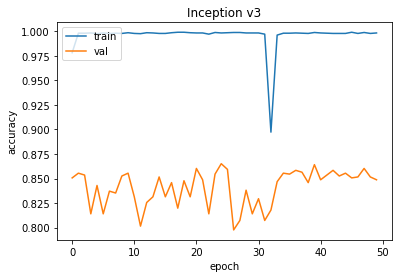

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       270
           1       0.88      0.71      0.79       228
           2       0.80      0.86      0.83       360
           3       0.94      0.97      0.95       180

    accuracy                           0.85      1038
   macro avg       0.86      0.85      0.86      1038
weighted avg       0.85      0.85      0.85      1038



In [42]:
from matplotlib import pyplot as plt

model = keras.models.load_model('./model_Inceptionv3.h5')
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(
        X_train,y_train,
        batch_size=100,
        epochs=50,
        validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inception v3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from sklearn.metrics import classification_report
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print(classification_report(np.argmax(y_test,1),y_pred))

In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,2])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()

ValueError: multiclass format is not supported

In [16]:
import numpy as geek
pred_masks = model.predict(CTimages, verbose=1)
pred_masks = (pred_masks>0.5).astype(np.float32)
print(pred_masks.shape)
CTimages_segmentation = geek.multiply(CTimages, pred_masks)



27/27 [==============================] - 393s 15s/step
(861, 256, 256, 1)


(861, 256, 256, 3)
0.5241935483870968


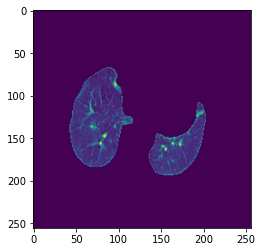

In [17]:
plt.imshow(CTimages_segmentation[0,:,:,1])
print(CTimages_segmentation.shape)
print(CTimages_segmentation[3,:,:,0].max())

(600, 256, 256, 1)
(261, 256, 256, 1)
(600, 256, 256, 1)
(261, 256, 256, 1)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03629032 0.10080645 0.0766129  0.01209677 0.00403226 0.00806452
 0.06451613 0.10080645 0.03629032 0.01612903 0.21774194 0.48790323
 0.53629032 0.47177419 0.44758065 0.44354839 0.43548387 0.43548387
 0.43145161 0.43145161 0.44758065 0.4516129  0.44354839 0.43548387
 0.42741935 0.42741935 0.4516129  0.48387097 0.50403226 0.51209677
 0.51612903 0.52419355 0.55241935 0.61290323 0.62096774 0.60080645
 0.56854839 0.52016129 0.48387097 0.41532258 0.34274194 0.35080645
 0.41129032 0.41532258 0.32258065 0.18548387 0.10887097 0.08870968
 0.0766129  0.06451613 0.08467742 0.11290323 0.14516129 0.2016129
 0.23790323 0.28225806 0.33870968 0.35887097 0.35080645 0.33467742
 0.3266129  0.3266129  0.31451613 0.32258065 0.33064516 0.31048387
 0.30645161

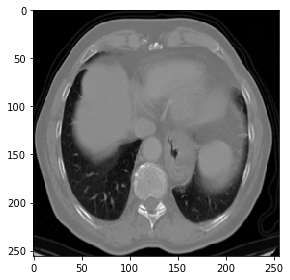

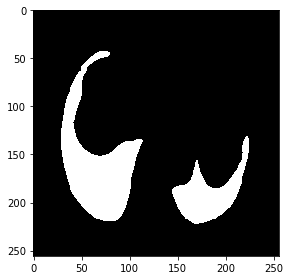

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from skimage.io import imread, imshow

indices = CTimages_segmentation > 0
CTimages_segmentation[indices]=1
CTclass = np.zeros((861,256,256,1))
CTclass = CTimages_segmentation[:,:,:,0]
CTclass = np.expand_dims(CTclass,axis=-1)

X_train = CTimages[:600,:,:,:1]
X_test = CTimages[600:,:,:,:1]
y_train = CTclass[:600]
y_test = CTclass[600:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train[3,:,50,0])
print(y_train[3,:,50,0])
imshow(np.squeeze(X_train[3]))
plt.show()
imshow(np.squeeze(y_train[3]))
plt.show()


In [18]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(1,))
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(16, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        print(x)
        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

img_size=(256,256)
num_classes=1
# Build model
model = get_model(img_size, num_classes)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='batch_normalization_8/FusedBatchNormV3:0', description="created by layer 'batch_normalization_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='batch_normalization_10/FusedBatchNormV3:0', description="created by layer 'batch_normalization_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='batch_normalization_12/FusedBatchNormV3:0', description="created by layer 'batch_normalization_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='batch_normalization_14/FusedBatchNormV3:0', description="created by layer 'batch_normalization_14'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

In [27]:
from keras.applications.resnet50 import ResNet50
#from keras.applications import MobileNetV2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Input, SeparableConv2D, UpSampling2D
from keras import backend as K
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
import keras

img_size=(256,256)
num_classes=1

inputs = keras.Input(shape=img_size+(1,))
### [First half of the network: downsampling inputs] ###

# Entry block
x = Conv2D(16, 3, strides=2, padding="same")(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)

print(x.shape)

previous_block_activation = x  # Set aside residual

# Blocks 1, 2, 3 are identical apart from the feature depth.
for filters in [64]:

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = Activation("relu")(x)
    x = SeparableConv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual


for filters in [64, 32]:

    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2DTranspose(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)

    # Project residual
    residual = UpSampling2D(2)(previous_block_activation)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

'''x = Conv2DTranspose(64, 3, padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D(2)(x)'''
# Add a per-pixel classification layer
outputs = Conv2D(num_classes, 1, activation="relu", padding="same")(x)

# Define the model
model = keras.models.Model(inputs, outputs)

model.summary()

(None, 128, 128, 16)
The following Variables were used a Lambda layer's call (tf.nn.conv2d_transpose), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_transpose_8/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_transpose_8/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.conv2d_transpose_1), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_transpose_9/kernel:0' shape=(3, 3, 64, 

In [28]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

history = model.fit(
        X_train,y_train,
        batch_size=16,
        epochs=100,
        validation_data=(X_test, y_test))


Epoch 1/100
38/38 [==============================] - 102s 2s/step - loss: 2.1574 - val_loss: 3.6438
Epoch 2/100
38/38 [==============================] - 83s 2s/step - loss: 0.8371 - val_loss: 3.6438
Epoch 3/100
38/38 [==============================] - 84s 2s/step - loss: 0.7870 - val_loss: 3.6438
Epoch 4/100
38/38 [==============================] - 82s 2s/step - loss: 0.6128 - val_loss: 3.6438
Epoch 5/100
38/38 [==============================] - 82s 2s/step - loss: 0.7197 - val_loss: 3.6438
Epoch 6/100
38/38 [==============================] - 2018s 54s/step - loss: 0.6918 - val_loss: 3.6438
Epoch 7/100
38/38 [==============================] - 242s 6s/step - loss: 0.5279 - val_loss: 3.6438
Epoch 8/100
38/38 [==============================] - 3271s 88s/step - loss: 0.5912 - val_loss: 3.6438
Epoch 9/100
38/38 [==============================] - 13149s 355s/step - loss: 0.5526 - val_loss: 3.6438
Epoch 10/100
38/38 [==============================] - 2762s 74s/step - loss: 0.4747 - val_loss: 

In [29]:
preds_val = model.predict(X_train, verbose=1)
preds_val_t = (preds_val > 0.5)


19/19 [==============================] - 31s 1s/step


In [30]:
print(preds_val.max())
print(preds_val.min())



2.295436
0.0


/Users/sunjianxing/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


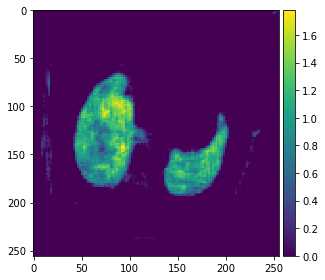

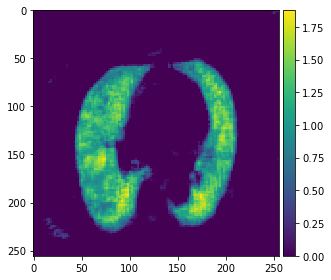

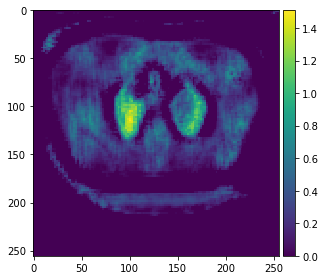

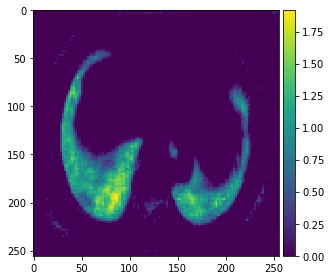

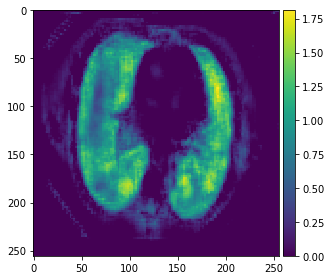

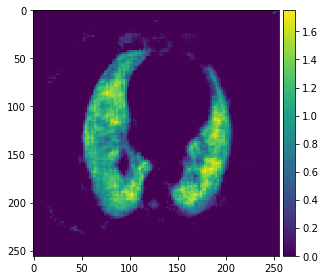

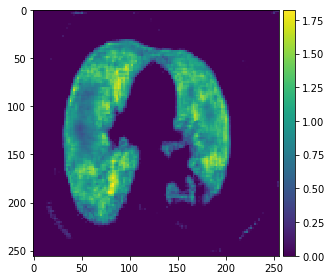

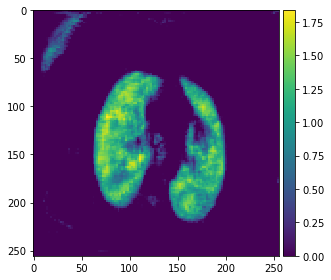

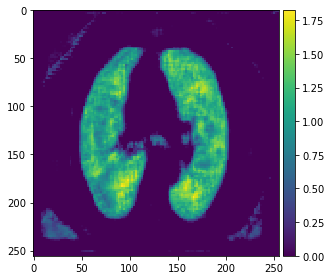

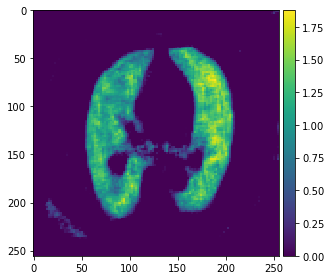

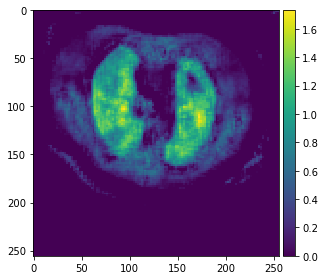

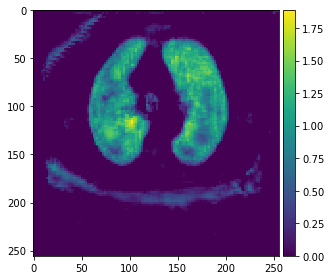

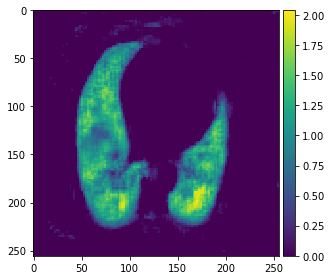

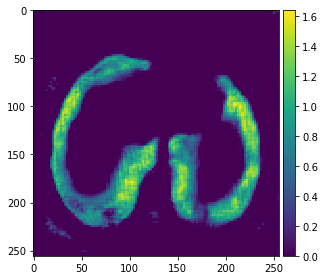

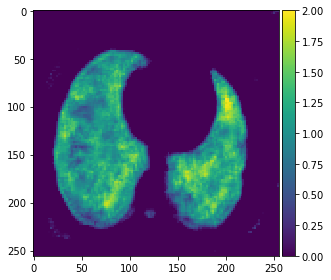

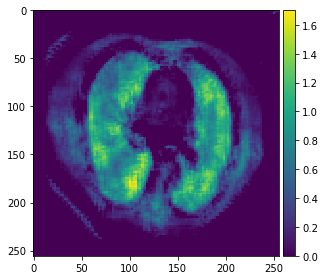

In [31]:
for i in range(16):
    imshow(np.squeeze(preds_val[i,:,:]))
    plt.show()

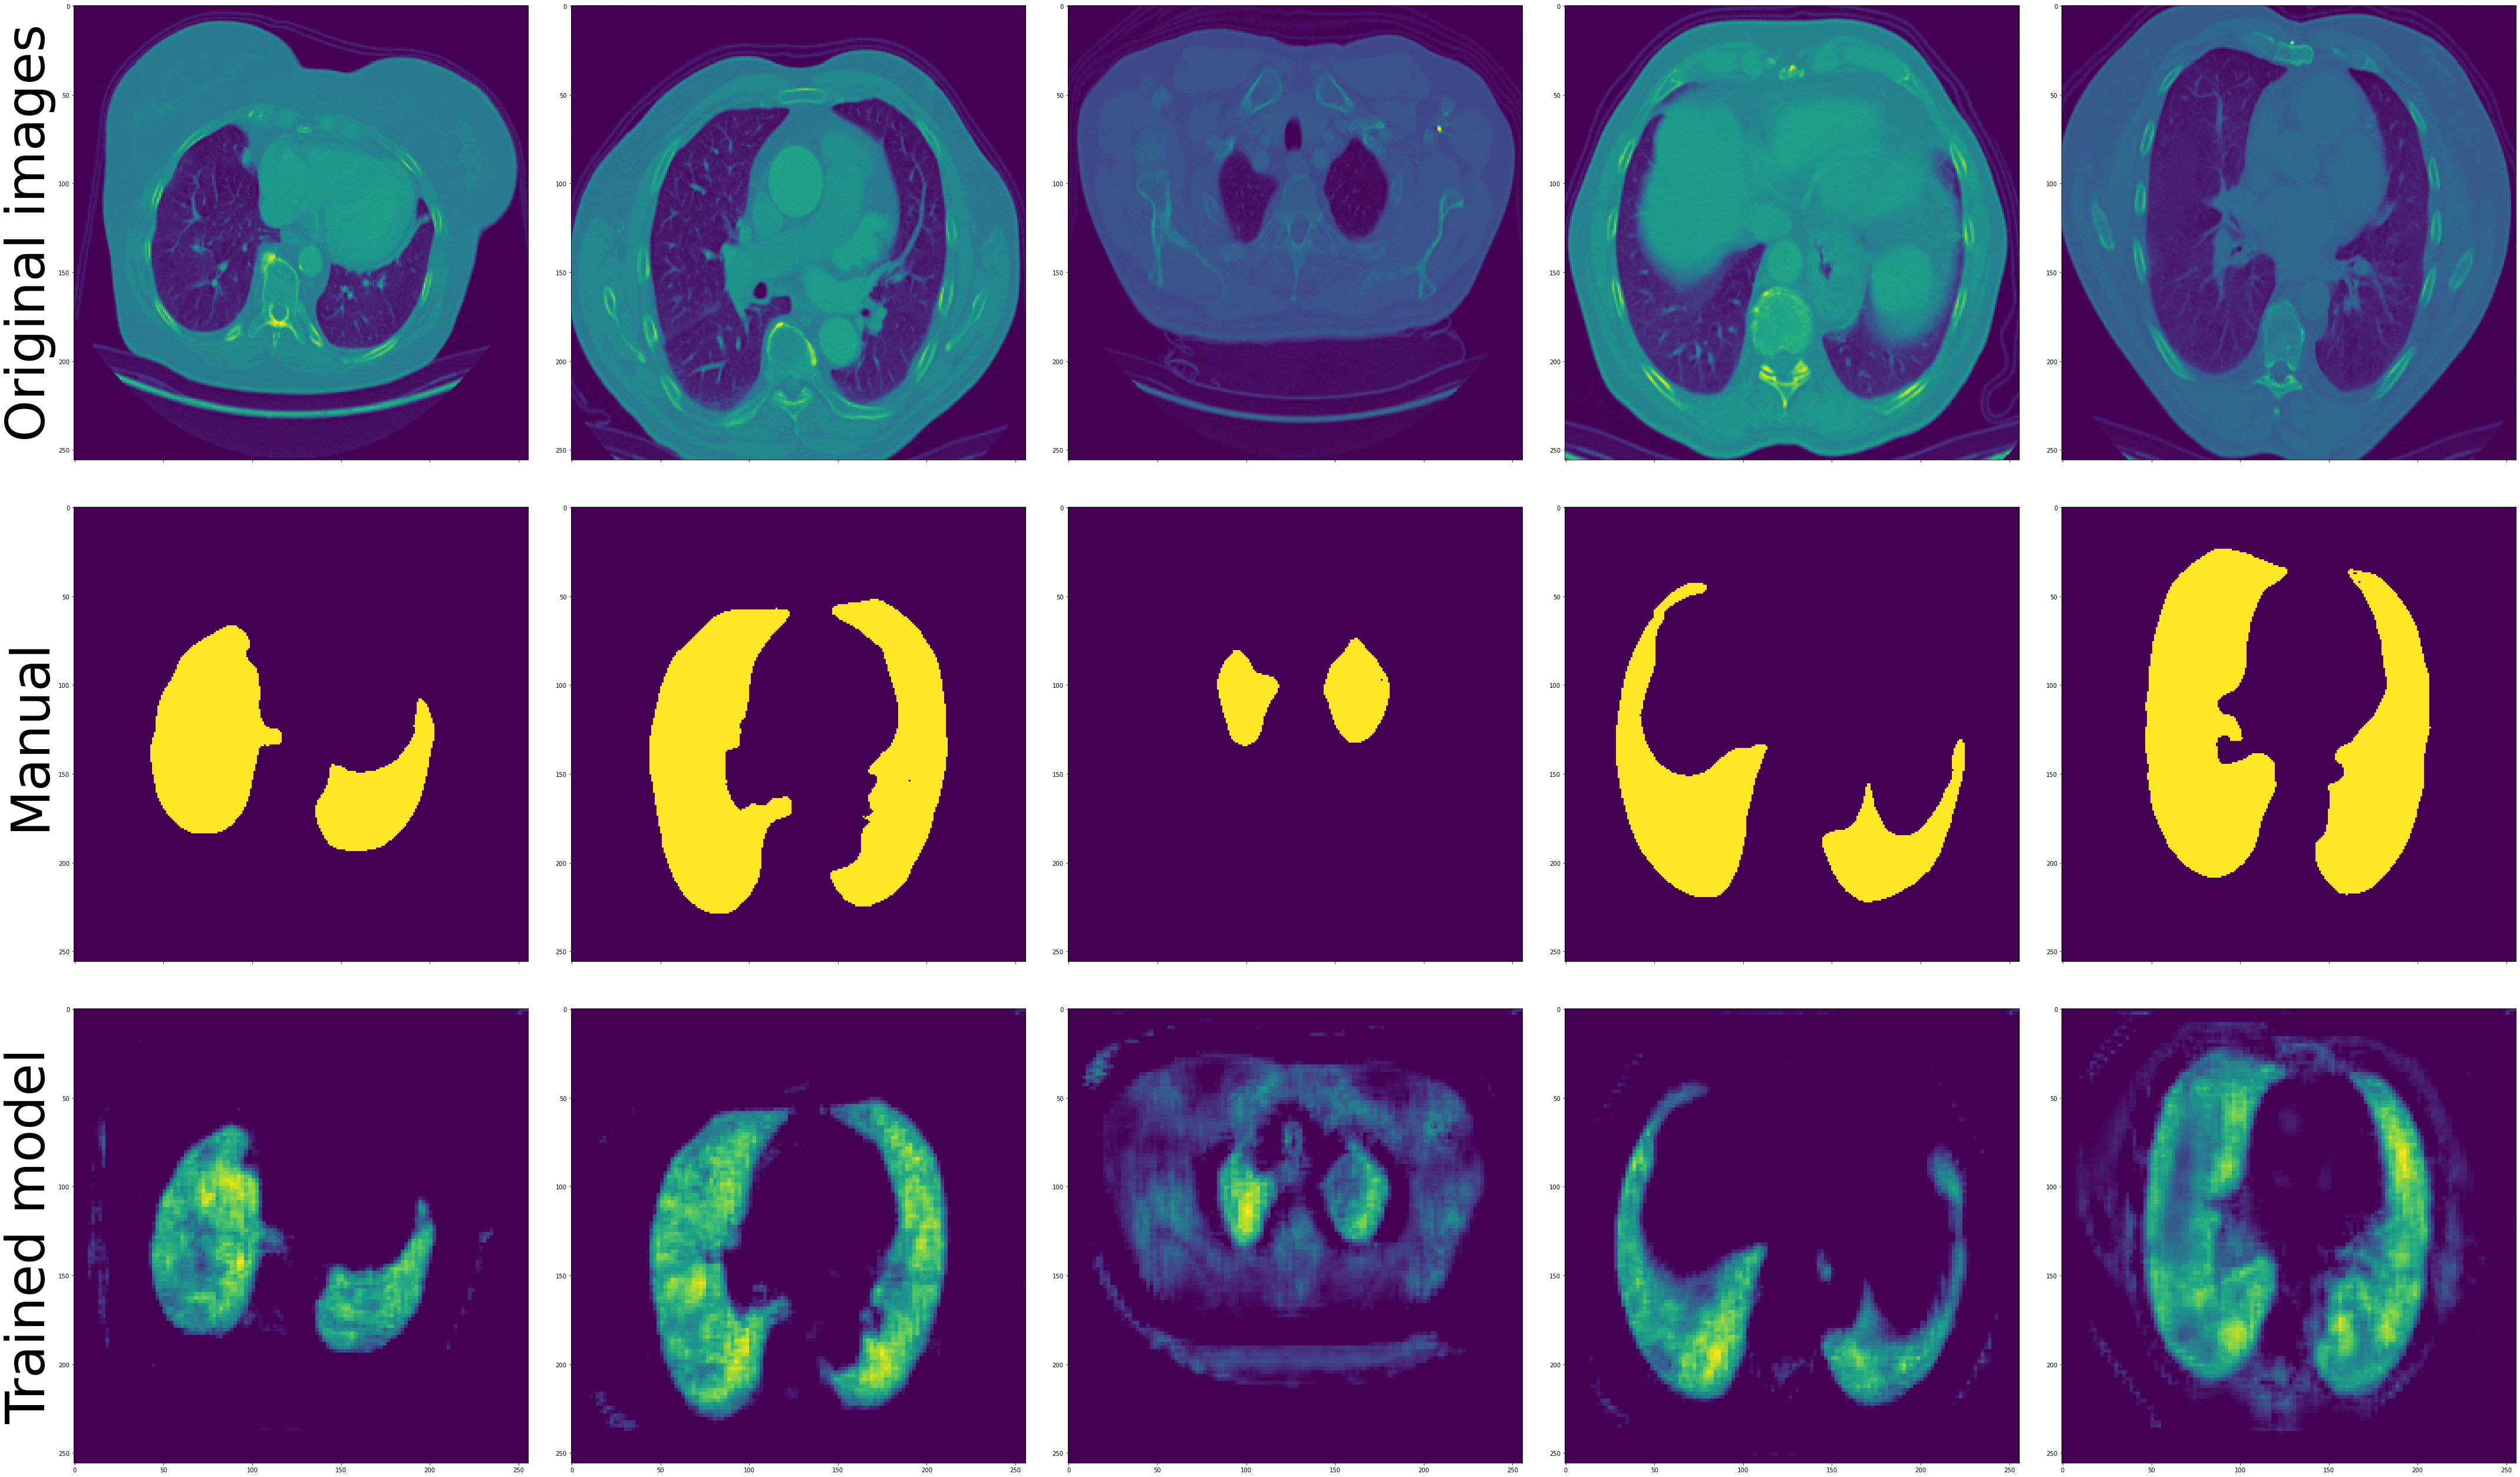

In [32]:
from matplotlib.transforms import offset_copy
pad = 5
fig,ax = plt.subplots(3,5, sharex=True, figsize=(60,36))

cols = ['Column {}'.format(col) for col in range(1, 4)]
rows = ['Original images','Manual','Trained model']


for axs, row in zip(ax[:,0], rows):
    axs.set_ylabel(row, size='90')


for i in range(5):    
    ax[0,i].imshow(np.squeeze(X_train[i]))
    #ax[0,i].axis('off')
for i in range(5):
    ax[1,i].imshow(np.squeeze(y_train[i]))
    #ax[1,i].axis('off')
for i in range(5):
    ax[2,i].imshow(np.squeeze(preds_val[i,:,:]))
    #ax[2,i].axis('off')
    
fig.tight_layout()
plt.savefig('./images/Unet',dpi=200)
plt.show()
